# Tri-Mouse Dataset Example with One-class Override

Train dataset: [https://zenodo.org/records/5851157](https://zenodo.org/records/5851157)

Test dataset: [https://zenodo.org/records/8437103](https://zenodo.org/records/8437103)

## Preparation
1. Download and extract the training dataset.

In [1]:
%%bash

# Define variables
TARGET_DIR="dataset/trimice-train/"
ZIP_FILE="trimice-train-dataset.zip"
URL="https://zenodo.org/records/5851157/files/trimice-dlc-2021-06-22.zip?download=1"

# Check if the directory exists
if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    # Download the file
    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    # Create parent directories
    mkdir -p "$TARGET_DIR"

    # Unzip the file
    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    # Remove the zip file
    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded train dataset."

dataset/trimice-train/ already exists. Skipping download and extraction.
Successfully downloaded train dataset.


2. Similarly, download and extract test dataset.

In [2]:
%%bash

TARGET_DIR="dataset/trimice-test/"
ZIP_FILE="trimice-test-dataset.zip"
URL="https://zenodo.org/records/8437103/files/trimice-dlc-2021-06-22.zip?download=1"

if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    mkdir -p "$TARGET_DIR"

    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded test dataset."

dataset/trimice-test/ already exists. Skipping download and extraction.
Successfully downloaded test dataset.


3. Download dependecies

In [3]:
%pip install --upgrade ultralytics deeplabcut2yolo

## Convert DeepLabCut (DLC) to YOLO

1. Setup the arguments for d2y.

In [9]:
import deeplabcut2yolo as d2y
from pathlib import Path

dataset_path = Path("dataset/trimice-train/trimice-dlc-2021-06-22")  # Dataset directory to convert using d2y
# Note that the test dataset has no label and does not need to be converted

# List of directories (the image folders) for validation and training.
val_paths = list(dataset_path.glob("labeled-data/*short/"))
train_paths = [item for item in dataset_path.glob("labeled-data/*/") if item not in val_paths and item.suffix != ".cache"]  # Directories that don't contain the word "short"

# The skeleton from the trimouse dataset is ["snout", "leftear", "rightear", "shoulder", "spine1", "spine2", "spine3", "spine4", "tailbase", "tail1", "tail2", "tailend"].
# The only parts that are symmetric are the leftear (index 1) and the rightear (index 2)
skeleton_symmetric_pairs=[(1, 2)]

# Overriding classes
override_classes = [0, 0, 0]  # Or "000"
class_names = ["mouse"]

2. Run the conversion.

In [10]:
d2y.convert(
    dataset_path=dataset_path,
    train_paths=train_paths,
    val_paths=val_paths,
    skeleton_symmetric_pairs=skeleton_symmetric_pairs,
    data_yml_path="data.yml",
    override_classes=override_classes,
    class_names=class_names,
    verbose=True,
)

DeepLabCut2YOLO

Dataset path: dataset/trimice-train/trimice-dlc-2021-06-22
Found pickled labels: dataset/trimice-train/trimice-dlc-2021-06-22/training-datasets/iteration-0/UnaugmentedDataSet_trimiceJun22/trimice_dlc70shuffle1.pickle
Found config file: dataset/trimice-train/trimice-dlc-2021-06-22/config.yaml
  nc: 3
  names: {0: 'mus1', 1: 'mus2', 2: 'mus3'}
  kpt: ['snout', 'leftear', 'rightear', 'shoulder', 'spine1', 'spine2', 'spine3', 'spine4', 'tailbase', 'tail1', 'tail2', 'tailend']
  kpt_shape: [12, 3]
Overrided class indices with: (0, 0, 0)
Generating data.yml...
Created data.yml: data.yml
  path: /content
  train: ['dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed2', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed20', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed4', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-d

100%|██████████| 112/112 [00:00<00:00, 2895.69it/s]


Conversion completed!


## YOLO Transfer Learning

In [11]:
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt").load('yolov8n-pose.pt')
model.train(data="data.yml", epochs=10, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.52M/6.52M [00:00<00:00, 96.2MB/s]


Transferred 397/397 items from pretrained weights
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n-pose.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 18.6MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[12, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1 

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<00:00, 791.08it/s]

train: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 822.02it/s]

val: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short.cache


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.3G      3.526      10.69     0.7386      3.449      3.208         40        640: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         50        150     0.0609        0.4     0.0547     0.0182    0.00102    0.00667   0.000547   0.000106



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.24G      3.507      10.64      0.733      3.351      3.253         41        640: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         50        150      0.111      0.173      0.085     0.0263   0.000481    0.00667    0.00026   5.04e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.23G       2.82       10.7     0.7193      2.547      2.436         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         50        150      0.234      0.347      0.186     0.0653    0.00158    0.00667   0.000123   1.75e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.24G      2.175      10.62     0.7068      1.965      1.799         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         50        150      0.387      0.507      0.469      0.188    0.00166     0.0133   0.000102   1.02e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.25G      1.847      10.31     0.6912       1.67      1.558         40        640: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         50        150      0.637      0.703       0.69       0.31   0.000428    0.00667   0.000124   1.24e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.26G      1.696      10.09     0.6799      1.437       1.45         41        640: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         50        150      0.688       0.78      0.695      0.311     0.0208    0.00667   0.000324   7.61e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.25G      1.514      9.899     0.6732      1.226      1.339         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         50        150       0.68      0.833       0.73      0.374    0.00148     0.0133    0.00015    1.5e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.25G      1.412      9.916     0.6654      1.131      1.252         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         50        150      0.686      0.873      0.765      0.396     0.0202    0.00667   0.000501   5.01e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.25G      1.372      9.612     0.6549       1.11      1.257         41        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         50        150       0.68      0.873      0.815      0.458     0.0256     0.0133   0.000972   9.72e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.25G      1.198      9.568     0.6437     0.9532      1.145         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         50        150      0.748      0.887      0.839      0.487     0.0294     0.0133    0.00134   0.000134



10 epochs completed in 0.011 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.6MB

Validating runs/pose/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,190,199 parameters, 0 gradients, 8.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


                   all         50        150       0.75      0.887      0.839      0.486     0.0294     0.0133    0.00131   0.000131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/pose/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8a676f6c20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

Here are the results from the transfer learning.

Training Images


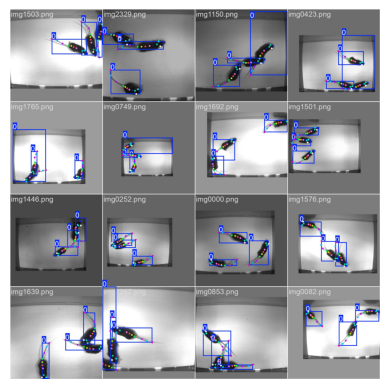

Validation Images


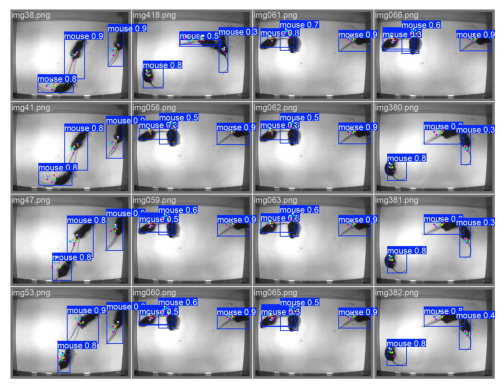

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

print("Training Images")
image = Image.open(Path("/content/runs/pose/train/train_batch1.jpg"))
plt.imshow(image)
plt.axis('off')
plt.show()

print("Validation Images")
image = Image.open(Path("/content/runs/pose/train/val_batch1_pred.jpg"))
plt.imshow(image)
plt.axis('off')
plt.show()

## Test the Model

In [13]:
image_paths=list(Path("/content/dataset/trimice-test/trimice-dlc-2021-06-22/labeled-data/videocompressed0").glob("*"))
results = model(image_paths)


0: 480x640 2 mouses, 8.5ms
1: 480x640 3 mouses, 8.5ms
2: 480x640 4 mouses, 8.5ms
3: 480x640 1 mouse, 8.5ms
4: 480x640 3 mouses, 8.5ms
5: 480x640 5 mouses, 8.5ms
6: 480x640 3 mouses, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


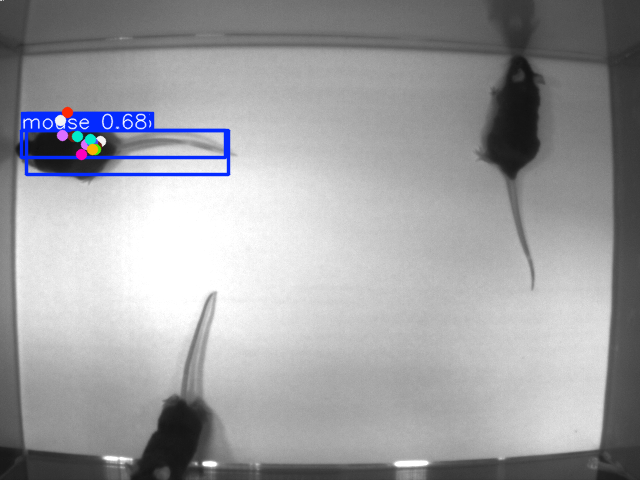

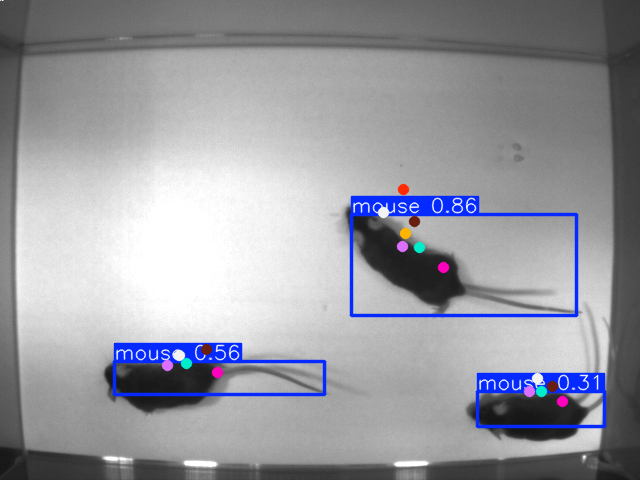

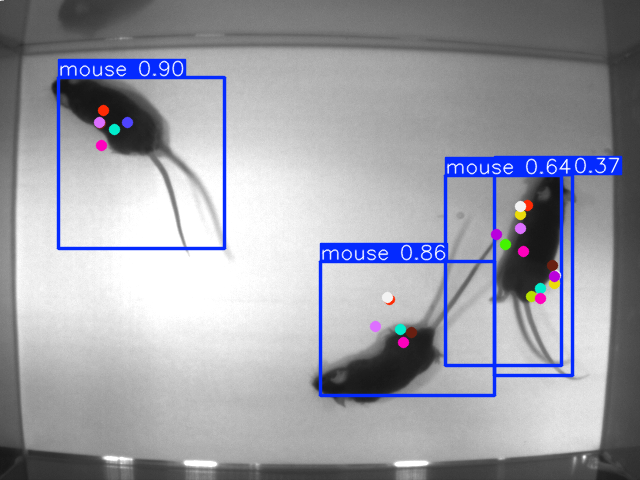

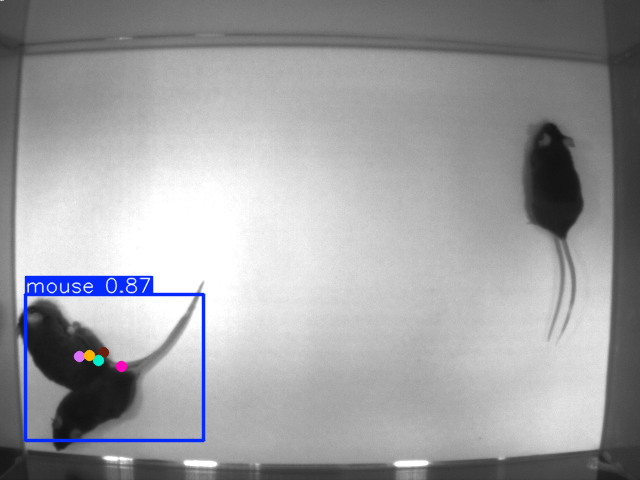

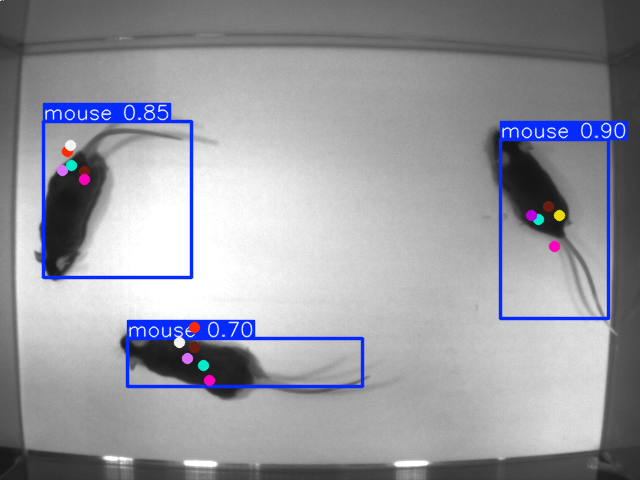

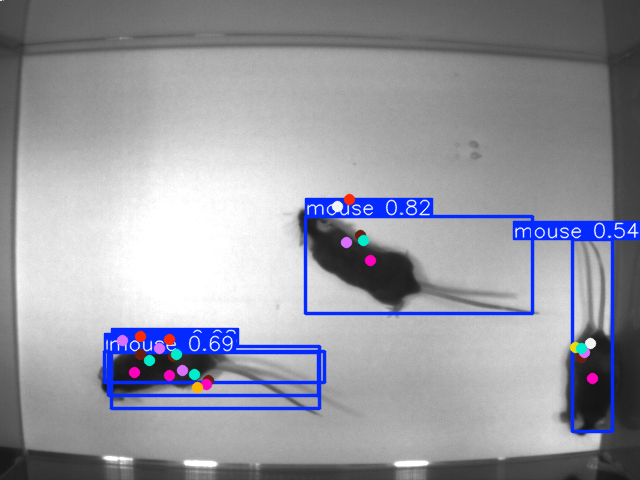

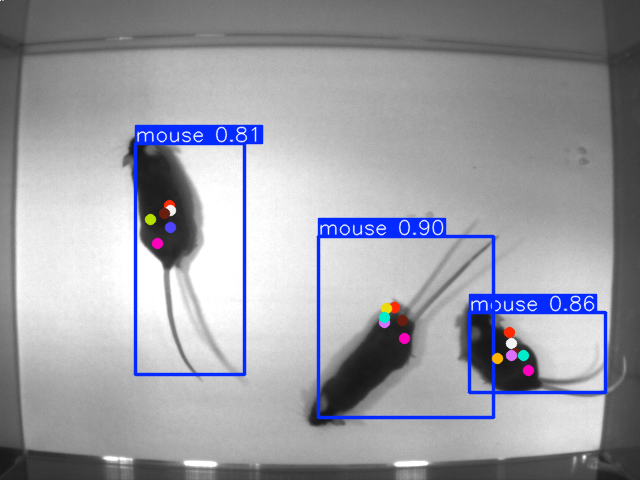

In [14]:
for r in results:
  r.show()